In [2]:
import os
os.chdir('/content/drive/MyDrive/yeonjun/공부/RecSys/intro_to_recsys/data')

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

from tqdm.notebook import tqdm

import warnings, random
warnings.filterwarnings('ignore')

In [4]:
train = np.load('./ml-100k/ml_100k_train.npy')
test = np.load('./ml-100k/ml_100k_test.npy')

In [5]:
train = np.array(train > 0, dtype=float)

In [6]:
class Config:
    learning_rate = 0.01/2
    weight_decay = 0.1/2
    early_stopping_round = 0
    epochs = 50
    seed = 1995
    dim_f = 20
    alpha = 100
    bootstrap_proportion = 0.5
    
config = Config()

In [7]:
def item_per_user_dict(data):
    item_per_user = defaultdict(list)
    user_pos = np.nonzero(data != 0)[0]
    item_pos = np.nonzero(data != 0)[1]
    
    for u, i in zip(user_pos, item_pos):
        item_per_user[u].append(i)

    return item_per_user


In [48]:
class BPR_kNN:
    def __init__(self, train):
        self.data = train
        
        self.user_num = train.shape[0]
        self.item_num = train.shape[1]
        self.user_pos = train.nonzero()[0]
        self.item_pos = train.nonzero()[1]

        self.train_hist = defaultdict(list) 
        self.valid_hist = defaultdict(list)

        self.C = np.random.standard_normal((self.item_num, self.item_num))

    def sampling_uij(self, item_per_user):    
        u = np.random.choice(self.user_num)
        rated_items = item_per_user[u]
        i = np.random.choice(rated_items)
        j = np.random.choice(self.item_num)

        return u, i, j, rated_items

    def fit(self):
        self.train_per_user, self.test_per_user = self.train_test_split(self.data)

        n = len(self.user_pos)
        for epoch in range(config.epochs):
            preds = []
            num_update_per_epoch = 0
            while num_update_per_epoch <= n*config.bootstrap_proportion:
                u, i, j, rated_items = self.sampling_uij(self.train_per_user)
                if j not in rated_items:
                    xuij = self.gradient_descent(u, i, j)        
                    num_update_per_epoch += 1    
                    preds.append(xuij)

            auc = np.where(np.array(preds) > 0, 1, 0).mean()
            auc_vl = self.evaluate(self.train_per_user, self.test_per_user)
            self.train_hist[epoch] = auc; self.valid_hist[epoch] = auc_vl
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print(f'EPOCH {epoch+1} TRAIN AUC: {auc}, TEST AUC {auc_vl}')
    
    def scoring(self, u, i, j):
        self.l_i = list(set(self.train_per_user[u]) - set([i]))
        xui = self.C[i, self.l_i].sum()
        
        self.l_j = list(set(self.train_per_user[u]) - set([j]))
        xuj = self.C[j, self.l_j].sum()

        xuij = np.clip(xui - xuj, -500, 500) 
        
        return xui, xuj, xuij 
    
    def gradient(self, u, i, j):
        xui, xuj, xuij = self.scoring(u, i, j)
        common_term = np.exp(-xuij) / (np.exp(-xuij) + 1)
        
        dci = common_term + config.weight_decay*self.C[i, self.l_i]
        dcj = -common_term + config.weight_decay*self.C[j, self.l_j]
        return dci, dcj, xuij
    
    def gradient_descent(self, u, i, j):
        dci, dcj, xuij = self.gradient(u, i, j)

        self.C[i, self.l_i] = self.C[i, self.l_i] + config.learning_rate*dci
        self.C[j, self.l_j] = self.C[j, self.l_j] + config.learning_rate*dcj
        return xuij

    def train_test_split(self, data):
        train_per_user = item_per_user_dict(data)
        test_per_user = {}
        for u in range(self.user_num):
            temp = train_per_user[u]
            length = len(temp)
            test_per_user[u] = temp.pop(np.random.choice(length))
            train_per_user[u] = temp

        return train_per_user, test_per_user

    def evaluate(self, train_per_user, test_per_user):
        item_idx = set(np.arange(self.item_num))
        auc = []
        for u in range(self.user_num):
            i = test_per_user[u]
            l = list(set(train_per_user[u]) - set([i]))
            j_s = list(item_idx - set(train_per_user[u]))
            
            xui = self.C[i, l].sum()
            xuj = self.C[:, l].sum(axis=1)[j_s]
            auc.append(np.mean(np.where(xui - xuj > 0, 1, 0)))
        return np.mean(auc)

    def plot_loss(self):
        fig, ax = plt.subplots(1,1, figsize=(10, 5))
        
        ax.plot(list(self.train_hist.keys()), list(self.train_hist.values()), color='orange', label='train')
        ax.plot(list(self.valid_hist.keys()), list(self.valid_hist.values()), color='green', label='valid')
        plt.legend()
        plt.show()

        

In [49]:
model = BPR_kNN(train)

In [50]:
model.fit()

EPOCH 1 TRAIN AUC: 0.5344616384590385, TEST AUC 0.558658366941182
EPOCH 10 TRAIN AUC: 0.7682307942301443, TEST AUC 0.7450999552628779
EPOCH 20 TRAIN AUC: 0.8283292917677058, TEST AUC 0.7929130773075654
EPOCH 30 TRAIN AUC: 0.8628034299142522, TEST AUC 0.8137371311317934
EPOCH 40 TRAIN AUC: 0.8810029749256268, TEST AUC 0.8270152791584207
EPOCH 50 TRAIN AUC: 0.8922276943076423, TEST AUC 0.8360163817503997


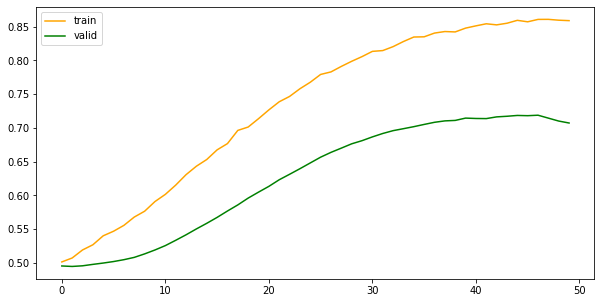

In [ ]:
model.plot_loss()